# ___XGBoost - Supervised Boosting Learning___
---

## ___What is XGBoost?___

_XGBoost stands for __eXtreme Gradient Boosting__._

_The name xgboost, though, actually refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. Which is the reason why many people use xgboost._

## ___XGBoost Features___
_The library is laser focused on computational speed and model performance, as such there are few frills. Nevertheless, it does offer a number of advanced features._

### ___Model Features___

_Three main forms of gradient boosting are supported:_

* ___Gradient Boosting algorithm___ _also called gradient boosting machine including the learning rate._
* ___Stochastic Gradient Boosting___ _with sub-sampling at the row, column and column per split levels._
* ___Regularized Gradient Boosting___ _with both L1 and L2 regularization._

### ___System Features___
_The library provides a system for use in a range of computing environments, not least:_

* ___Parallelization of tree construction___ _using all of your CPU cores during training._
* ___Distributed Computing___ _for training very large models using a cluster of machines._
* ___Out-of-Core Computing___ _for very large datasets that don’t fit into memory._
* ___Cache Optimization___ _of data structures and algorithm to make best use of hardware._

### ___Algorithm Features___
_The implementation of the algorithm was engineered for efficiency of compute time and memory resources. A design goal was to make the best use of available resources to train the model. Some key algorithm implementation features include:_

* ___Sparse Aware___ _implementation with automatic handling of missing data values._
* ___Block Structure___ _to support the parallelization of tree construction._
* ___Continued Training___ _so that you can further boost an already fitted model on new data._

_XGBoost is free open source software available for use under the permissive Apache-2 license._

## ___Why Use XGBoost?___
_The two reasons to use XGBoost are also the two goals of the project:_

* ___Execution Speed___
* ___Model Performance___

## ___XGBoost for Regression___

___Step 1:___
_Make initial prediction 0.5._

___Step 2:___
_Build XGBoost trees and calculate the residuals, with those residuals calculate the similarity scores and gain._

$$Similarity score = sqrd(sum of residuals)/(no. of residuals + lambda)$$

_and_

$$Gain = Left Similarity + Right Similarity - Root Similarity$$

_to determine how to split the data._

___Step 3:___
_Prune the tree by calculating the differencce between the Gain and Gamma_

$$Pruning = Gain - Gamma$$

_if difference is negative then prune, else do not prune._

___Step 4:___
_Then calculate the output values of the remaining leaves_

$$Output Values = Sum of Residuals/(no. of residuals + lambda)$$

_lambda is regularization parameter, larger vlaue of Gamma leads to more pruning by shrinking similarity score and smaller output value._

___Step 5:___ 
_Then using the initial prediction + learning rate * output value get the new value and calculate the residuals, and repeat step 1 to 5 to get the final value._

_[Reference](https://www.youtube.com/watch?v=OtD8wVaFm6E)_

## ___XGBoost for Classification___

___Step 1:___ _Make initial prediction as 0.5._

___Step 2:___ _Calculate similarity score_

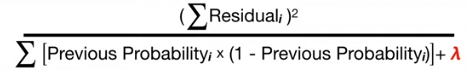

___Step 3:___ _Prune the tree using gamma and calculate the output value without squaring the numerator._

___Step 4:___ _Calculate the log(odds) for initial prediction + learning rate * output value, this will give the log(odds) for the prediction then convert it back to probability using logisitic function._

___Step 5:___ _Repeat the steps to come closer to final probability value and prediction._

_[Reference](https://www.youtube.com/watch?v=8b1JEDvenQU)_

In [38]:
# Import warnings and add a filter to ignore them
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# XGBoost Classifier
from xgboost import XGBClassifier
# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error

# Cross validation
from sklearn.model_selection import KFold, train_test_split, cross_val_score,RandomizedSearchCV, GridSearchCV

# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sns

# For data manipulation
import pandas as pd
import numpy as np

In [11]:
# Importing the dataset
df = pd.read_csv(r'C:\Users\PiyushSin\Desktop\datasets\Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


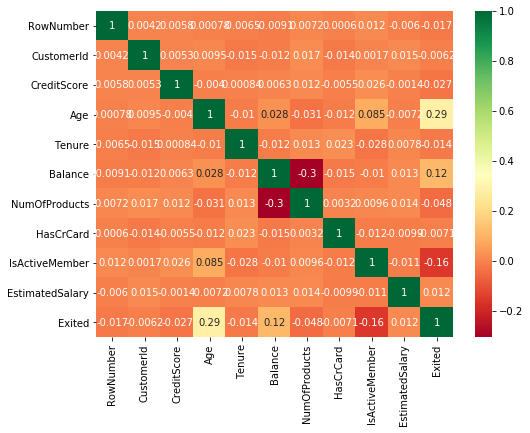

In [13]:
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,6))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [14]:
#Get the Independent and Dependent Features
X=df.iloc[:,3:13]
Y=df.iloc[:,13]

In [15]:
geography=pd.get_dummies(X['Geography'],drop_first=True)

In [16]:
gender=pd.get_dummies(X['Gender'],drop_first=True)

In [17]:
## Drop Categorical Features
X=X.drop(['Geography','Gender'],axis=1)

In [18]:
X=pd.concat([X,geography,gender],axis=1)

In [19]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [21]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]    
}

In [40]:
classifier=XGBClassifier()

In [23]:
random_search=RandomizedSearchCV(classifier, param_distributions=params,
                                 n_iter=5, scoring='roc_auc',
                                 n_jobs=-1, cv=5, verbose=3)

In [24]:
random_search.fit(X,Y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   43.6s finished


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [25]:
random_search.best_estimator_

XGBClassifier(colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=4,
              min_child_weight=3)

In [26]:
random_search.best_params_

{'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.15,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [27]:
classifier=XGBClassifier(base_score=0.7, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.1, learning_rate=0.15,
       max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [28]:
score=cross_val_score(classifier,X,Y,cv=10)

In [29]:
score.mean()

0.8644999999999999

## ___XGBoost for Regression___

In [30]:
from sklearn.datasets import load_boston

In [31]:
boston = load_boston()
x, y = boston.data, boston.target
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)

In [32]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(verbosity=0)
xgbr.fit(xtrain, ytrain)

XGBRegressor(verbosity=0)

In [33]:
score = xgbr.score(xtrain, ytrain)  
print("Training score: ", score)

Training score:  0.9717178663068988


In [34]:
scores = cross_val_score(xgbr, xtrain, ytrain,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.86


In [35]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.87


In [39]:
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))

MSE: 14.94
RMSE: 7.47


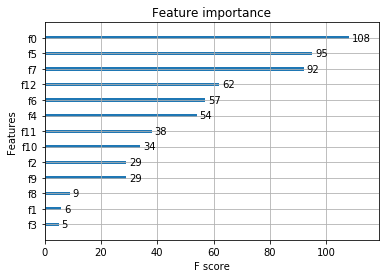

In [41]:
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

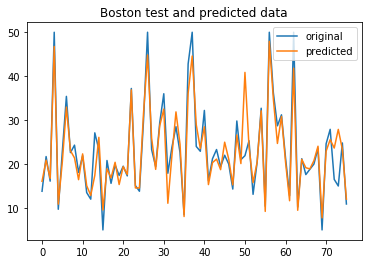

In [37]:
x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

## ___Hyperparamters in XGBoost___

* ___learning_rate:___ _step size shrinkage used to prevent overfitting. Range is [0,1]_
* ___max_depth:___ _determines how deeply each tree is allowed to grow during any boosting round._
* ___subsample:___ _percentage of samples used per tree. Low value can lead to underfitting._
* ___colsample_bytree:___ _percentage of features used per tree. High value can lead to overfitting._
* ___n_estimators:___ _number of trees you want to build._
* ___objective:___ _determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability._

_XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models._

* ___gamma:___ _controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners._
* ___alpha:___ _L1 regularization on leaf weights. A large value leads to more regularization._
* ___lambda:___ _L2 regularization on leaf weights and is smoother than L1 regularization._